In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import preprocessing
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Generate training data with a constant noise

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon
train_size = 100
noise = 0.3  # CHOOSE THE NOISE 
X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
Y = f(X, sigma=noise)
Y_true = f(X, sigma=0.0)
print(X.shape)

(100, 1)


Visualize training data

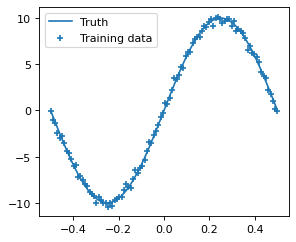

In [3]:
cm = 1/2.54 
fig, ax = plt.subplots(1, figsize=(9*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.scatter(X, Y, marker='+', label='Training data')
ax.plot(X, Y_true, label='Truth')
plt.legend()

Loss function, Distribution layer, and KL diverenge

In [4]:
def NLL(y, distr): 
  return -distr.log_prob(y) 


def normal_sp(params): 
  return tfp.distributions.Normal(loc=params, scale=noise) # CHOOSE THE SCALE PARAMETER (only the mean parameter is learnable)


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0])
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0])

Build the network

In [5]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
# CHOOSE THE NUMBER OF NEURONS IN EACH LAYER
hidden = tfp.layers.DenseFlipout(15,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(32,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(15,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(1,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(learning_rate=0.001), loss=NLL) # CHOOSE THE LEARNING RATE AND LOSS FUNCTION
model_params = Model(inputs=inputs, outputs=params)
model.summary()

C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 15)               60        
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 32)               1024      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 15)               990       
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 1)                32        
 ut)                                                         

Train the network

In [6]:
epoch = 3000
model.fit(X, Y, epochs=epoch, verbose=1)

Epoch 1/3000
4/4 [==============================] - 2s 2ms/step - loss: 299.3311
Epoch 2/3000
4/4 [==============================] - 0s 2ms/step - loss: 299.5511
Epoch 3/3000
4/4 [==============================] - 0s 2ms/step - loss: 299.7495
Epoch 4/3000
4/4 [==============================] - 0s 2ms/step - loss: 300.0153
Epoch 5/3000
4/4 [==============================] - 0s 2ms/step - loss: 299.3653
Epoch 6/3000
4/4 [==============================] - 0s 2ms/step - loss: 297.6298
Epoch 7/3000
4/4 [==============================] - 0s 1ms/step - loss: 299.6354
Epoch 8/3000
4/4 [==============================] - 0s 2ms/step - loss: 298.9436
Epoch 9/3000
4/4 [==============================] - 0s 2ms/step - loss: 299.1755
Epoch 10/3000
4/4 [==============================] - 0s 2ms/step - loss: 298.8881
Epoch 11/3000
4/4 [==============================] - 0s 2ms/step - loss: 298.8260
Epoch 12/3000
4/4 [==============================] - 0s 2ms/step - loss: 299.4778
Epoch 13/3000
4/4 [======

4/4 [==============================] - 0s 2ms/step - loss: 87.5609
Epoch 102/3000
4/4 [==============================] - 0s 2ms/step - loss: 90.6417
Epoch 103/3000
4/4 [==============================] - 0s 2ms/step - loss: 92.1419
Epoch 104/3000
4/4 [==============================] - 0s 2ms/step - loss: 92.3716
Epoch 105/3000
4/4 [==============================] - 0s 2ms/step - loss: 90.9357
Epoch 106/3000
4/4 [==============================] - 0s 2ms/step - loss: 92.1157
Epoch 107/3000
4/4 [==============================] - 0s 2ms/step - loss: 93.8423
Epoch 108/3000
4/4 [==============================] - 0s 2ms/step - loss: 92.6316
Epoch 109/3000
4/4 [==============================] - 0s 2ms/step - loss: 91.2661
Epoch 110/3000
4/4 [==============================] - 0s 2ms/step - loss: 91.0653
Epoch 111/3000
4/4 [==============================] - 0s 2ms/step - loss: 93.6611
Epoch 112/3000
4/4 [==============================] - 0s 2ms/step - loss: 94.1308
Epoch 113/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 80.1472
Epoch 202/3000
4/4 [==============================] - 0s 2ms/step - loss: 78.5337
Epoch 203/3000
4/4 [==============================] - 0s 2ms/step - loss: 78.3562
Epoch 204/3000
4/4 [==============================] - 0s 2ms/step - loss: 83.1720
Epoch 205/3000
4/4 [==============================] - 0s 2ms/step - loss: 80.0626
Epoch 206/3000
4/4 [==============================] - 0s 2ms/step - loss: 81.0754
Epoch 207/3000
4/4 [==============================] - 0s 2ms/step - loss: 83.5701
Epoch 208/3000
4/4 [==============================] - 0s 2ms/step - loss: 80.4542
Epoch 209/3000
4/4 [==============================] - 0s 2ms/step - loss: 84.1580
Epoch 210/3000
4/4 [==============================] - 0s 2ms/step - loss: 82.8680
Epoch 211/3000
4/4 [==============================] - 0s 2ms/step - loss: 81.1656
Epoch 212/3000
4/4 [==============================] - 0s 1ms/step - loss: 75.5667
Epoch 213/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 68.3639
Epoch 302/3000
4/4 [==============================] - 0s 2ms/step - loss: 66.7308
Epoch 303/3000
4/4 [==============================] - 0s 2ms/step - loss: 67.1142
Epoch 304/3000
4/4 [==============================] - 0s 2ms/step - loss: 68.3934
Epoch 305/3000
4/4 [==============================] - 0s 2ms/step - loss: 63.3864
Epoch 306/3000
4/4 [==============================] - 0s 2ms/step - loss: 61.5896
Epoch 307/3000
4/4 [==============================] - 0s 2ms/step - loss: 63.2707
Epoch 308/3000
4/4 [==============================] - 0s 2ms/step - loss: 68.8189
Epoch 309/3000
4/4 [==============================] - 0s 2ms/step - loss: 66.6701
Epoch 310/3000
4/4 [==============================] - 0s 2ms/step - loss: 62.4609
Epoch 311/3000
4/4 [==============================] - 0s 1ms/step - loss: 62.2339
Epoch 312/3000
4/4 [==============================] - 0s 2ms/step - loss: 61.3847
Epoch 313/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 51.1270
Epoch 402/3000
4/4 [==============================] - 0s 2ms/step - loss: 50.8219
Epoch 403/3000
4/4 [==============================] - 0s 2ms/step - loss: 52.1525
Epoch 404/3000
4/4 [==============================] - 0s 1ms/step - loss: 54.4557
Epoch 405/3000
4/4 [==============================] - 0s 2ms/step - loss: 50.4540
Epoch 406/3000
4/4 [==============================] - 0s 2ms/step - loss: 46.5393
Epoch 407/3000
4/4 [==============================] - 0s 1ms/step - loss: 47.7524
Epoch 408/3000
4/4 [==============================] - 0s 2ms/step - loss: 48.7439
Epoch 409/3000
4/4 [==============================] - 0s 2ms/step - loss: 48.0139
Epoch 410/3000
4/4 [==============================] - 0s 2ms/step - loss: 51.4974
Epoch 411/3000
4/4 [==============================] - 0s 2ms/step - loss: 48.2315
Epoch 412/3000
4/4 [==============================] - 0s 2ms/step - loss: 49.1443
Epoch 413/3000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 38.8185
Epoch 502/3000
4/4 [==============================] - 0s 2ms/step - loss: 41.5444
Epoch 503/3000
4/4 [==============================] - 0s 2ms/step - loss: 41.6760
Epoch 504/3000
4/4 [==============================] - 0s 2ms/step - loss: 40.7015
Epoch 505/3000
4/4 [==============================] - 0s 2ms/step - loss: 43.0544
Epoch 506/3000
4/4 [==============================] - 0s 2ms/step - loss: 37.5271
Epoch 507/3000
4/4 [==============================] - 0s 2ms/step - loss: 35.9765
Epoch 508/3000
4/4 [==============================] - 0s 2ms/step - loss: 37.9962
Epoch 509/3000
4/4 [==============================] - 0s 2ms/step - loss: 38.0482
Epoch 510/3000
4/4 [==============================] - 0s 2ms/step - loss: 39.5126
Epoch 511/3000
4/4 [==============================] - 0s 2ms/step - loss: 37.8540
Epoch 512/3000
4/4 [==============================] - 0s 1ms/step - loss: 37.1016
Epoch 513/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 31.3132
Epoch 602/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.8775
Epoch 603/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.7838
Epoch 604/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.8436
Epoch 605/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.1105
Epoch 606/3000
4/4 [==============================] - 0s 2ms/step - loss: 33.5464
Epoch 607/3000
4/4 [==============================] - 0s 2ms/step - loss: 35.3504
Epoch 608/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.1822
Epoch 609/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.6164
Epoch 610/3000
4/4 [==============================] - 0s 2ms/step - loss: 33.1988
Epoch 611/3000
4/4 [==============================] - 0s 2ms/step - loss: 34.4700
Epoch 612/3000
4/4 [==============================] - 0s 2ms/step - loss: 35.7555
Epoch 613/3000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 29.4423
Epoch 702/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.9965
Epoch 703/3000
4/4 [==============================] - 0s 2ms/step - loss: 32.2070
Epoch 704/3000
4/4 [==============================] - 0s 1ms/step - loss: 28.8964
Epoch 705/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.1132
Epoch 706/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.2299
Epoch 707/3000
4/4 [==============================] - 0s 2ms/step - loss: 32.0435
Epoch 708/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.8133
Epoch 709/3000
4/4 [==============================] - 0s 1ms/step - loss: 28.9309
Epoch 710/3000
4/4 [==============================] - 0s 2ms/step - loss: 28.7897
Epoch 711/3000
4/4 [==============================] - 0s 1ms/step - loss: 30.1953
Epoch 712/3000
4/4 [==============================] - 0s 2ms/step - loss: 31.7994
Epoch 713/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 29.6214
Epoch 802/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.4949
Epoch 803/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.5330
Epoch 804/3000
4/4 [==============================] - 0s 2ms/step - loss: 28.0755
Epoch 805/3000
4/4 [==============================] - 0s 2ms/step - loss: 28.5688
Epoch 806/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.9517
Epoch 807/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.1623
Epoch 808/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.4505
Epoch 809/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.2105
Epoch 810/3000
4/4 [==============================] - 0s 2ms/step - loss: 28.3336
Epoch 811/3000
4/4 [==============================] - 0s 2ms/step - loss: 27.7438
Epoch 812/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.8442
Epoch 813/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 25.4902
Epoch 902/3000
4/4 [==============================] - 0s 1ms/step - loss: 27.5178
Epoch 903/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.7106
Epoch 904/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.2208
Epoch 905/3000
4/4 [==============================] - 0s 2ms/step - loss: 27.2016
Epoch 906/3000
4/4 [==============================] - 0s 1ms/step - loss: 26.5306
Epoch 907/3000
4/4 [==============================] - 0s 2ms/step - loss: 28.0985
Epoch 908/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.4916
Epoch 909/3000
4/4 [==============================] - 0s 1ms/step - loss: 27.8254
Epoch 910/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.0511
Epoch 911/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.6437
Epoch 912/3000
4/4 [==============================] - 0s 2ms/step - loss: 27.0608
Epoch 913/3000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 26.1965
Epoch 1002/3000
4/4 [==============================] - 0s 1ms/step - loss: 27.2726
Epoch 1003/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.0263
Epoch 1004/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.8573
Epoch 1005/3000
4/4 [==============================] - 0s 2ms/step - loss: 27.6902
Epoch 1006/3000
4/4 [==============================] - 0s 2ms/step - loss: 30.1132
Epoch 1007/3000
4/4 [==============================] - 0s 1ms/step - loss: 26.2264
Epoch 1008/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.5781
Epoch 1009/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.9573
Epoch 1010/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.2658
Epoch 1011/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.2270
Epoch 1012/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.3033
Epoch 1013/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 24.4049
Epoch 1100/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.7686
Epoch 1101/3000
4/4 [==============================] - 0s 1ms/step - loss: 24.6607
Epoch 1102/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.6177
Epoch 1103/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.7233
Epoch 1104/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.1427
Epoch 1105/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.6330
Epoch 1106/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.2842
Epoch 1107/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.3639
Epoch 1108/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.4667
Epoch 1109/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.0284
Epoch 1110/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.0350
Epoch 1111/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 25.0217
Epoch 1198/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.7865
Epoch 1199/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.1157
Epoch 1200/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.1555
Epoch 1201/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.1105
Epoch 1202/3000
4/4 [==============================] - 0s 2ms/step - loss: 29.8278
Epoch 1203/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.4052
Epoch 1204/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.2138
Epoch 1205/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.8826
Epoch 1206/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.5116
Epoch 1207/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.0065
Epoch 1208/3000
4/4 [==============================] - 0s 2ms/step - loss: 26.2003
Epoch 1209/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 23.1328
Epoch 1296/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.6042
Epoch 1297/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.6679
Epoch 1298/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.6560
Epoch 1299/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.7213
Epoch 1300/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.6576
Epoch 1301/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.7121
Epoch 1302/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.6107
Epoch 1303/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.7612
Epoch 1304/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.5260
Epoch 1305/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.5461
Epoch 1306/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.0921
Epoch 1307/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 22.4482
Epoch 1394/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.4779
Epoch 1395/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.6156
Epoch 1396/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.3616
Epoch 1397/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.6475
Epoch 1398/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.2184
Epoch 1399/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.5778
Epoch 1400/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.7080
Epoch 1401/3000
4/4 [==============================] - 0s 2ms/step - loss: 25.4187
Epoch 1402/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.5104
Epoch 1403/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.2969
Epoch 1404/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.3358
Epoch 1405/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 21.2557
Epoch 1492/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.5980
Epoch 1493/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.6295
Epoch 1494/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.1230
Epoch 1495/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.1557
Epoch 1496/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.7753
Epoch 1497/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.8483
Epoch 1498/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.1807
Epoch 1499/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.8117
Epoch 1500/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.8170
Epoch 1501/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.8249
Epoch 1502/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.8228
Epoch 1503/3000
4/4 

4/4 [==============================] - 0s 1ms/step - loss: 22.7762
Epoch 1590/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.4700
Epoch 1591/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.7656
Epoch 1592/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.9256
Epoch 1593/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.8062
Epoch 1594/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.5245
Epoch 1595/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.5842
Epoch 1596/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.1189
Epoch 1597/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.2180
Epoch 1598/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.8484
Epoch 1599/3000
4/4 [==============================] - 0s 2ms/step - loss: 24.5119
Epoch 1600/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.7924
Epoch 1601/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 22.6328
Epoch 1688/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.1775
Epoch 1689/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.9705
Epoch 1690/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.3110
Epoch 1691/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.6742
Epoch 1692/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.6373
Epoch 1693/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.7681
Epoch 1694/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.4487
Epoch 1695/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.3945
Epoch 1696/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.2425
Epoch 1697/3000
4/4 [==============================] - 0s 2ms/step - loss: 23.0077
Epoch 1698/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.1491
Epoch 1699/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 21.8625
Epoch 1786/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.2168
Epoch 1787/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.7949
Epoch 1788/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.0216
Epoch 1789/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.7285
Epoch 1790/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.2120
Epoch 1791/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.0206
Epoch 1792/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.9011
Epoch 1793/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.7937
Epoch 1794/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.4508
Epoch 1795/3000
4/4 [==============================] - 0s 1ms/step - loss: 21.4096
Epoch 1796/3000
4/4 [==============================] - 0s 1ms/step - loss: 20.7971
Epoch 1797/3000
4/4 

4/4 [==============================] - 0s 1ms/step - loss: 21.4409
Epoch 1884/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.8199
Epoch 1885/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.4802
Epoch 1886/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.1849
Epoch 1887/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.7779
Epoch 1888/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.8230
Epoch 1889/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.0103
Epoch 1890/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.5999
Epoch 1891/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.5739
Epoch 1892/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.3439
Epoch 1893/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.7059
Epoch 1894/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.2971
Epoch 1895/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 20.8875
Epoch 1982/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.7227
Epoch 1983/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.1525
Epoch 1984/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.2280
Epoch 1985/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.6549
Epoch 1986/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.7730
Epoch 1987/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.1249
Epoch 1988/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.8428
Epoch 1989/3000
4/4 [==============================] - 0s 2ms/step - loss: 21.1463
Epoch 1990/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.9158
Epoch 1991/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.9979
Epoch 1992/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.8332
Epoch 1993/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 19.8638
Epoch 2080/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.2902
Epoch 2081/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.5793
Epoch 2082/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.1935
Epoch 2083/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.9833
Epoch 2084/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.8247
Epoch 2085/3000
4/4 [==============================] - 0s 1ms/step - loss: 20.2606
Epoch 2086/3000
4/4 [==============================] - 0s 1ms/step - loss: 20.8524
Epoch 2087/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.5565
Epoch 2088/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.0803
Epoch 2089/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.9967
Epoch 2090/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.5352
Epoch 2091/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 21.1697
Epoch 2178/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.9182
Epoch 2179/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.1901
Epoch 2180/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.2146
Epoch 2181/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.5638
Epoch 2182/3000
4/4 [==============================] - 0s 1ms/step - loss: 18.8661
Epoch 2183/3000
4/4 [==============================] - 0s 2ms/step - loss: 22.0967
Epoch 2184/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.0997
Epoch 2185/3000
4/4 [==============================] - 0s 2ms/step - loss: 20.1637
Epoch 2186/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.5479
Epoch 2187/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.4349
Epoch 2188/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.8748
Epoch 2189/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 19.4156
Epoch 2276/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.8001
Epoch 2277/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.7749
Epoch 2278/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.9207
Epoch 2279/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.9287
Epoch 2280/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.4680
Epoch 2281/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.3806
Epoch 2282/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.2353
Epoch 2283/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.7685
Epoch 2284/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.9462
Epoch 2285/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8672
Epoch 2286/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.5836
Epoch 2287/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 20.1649
Epoch 2374/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.7876
Epoch 2375/3000
4/4 [==============================] - 0s 1ms/step - loss: 20.0096
Epoch 2376/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.1677
Epoch 2377/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.3517
Epoch 2378/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.9289
Epoch 2379/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.0888
Epoch 2380/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4555
Epoch 2381/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.9370
Epoch 2382/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.2371
Epoch 2383/3000
4/4 [==============================] - 0s 1ms/step - loss: 18.7503
Epoch 2384/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.3860
Epoch 2385/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 18.7550
Epoch 2472/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.7464
Epoch 2473/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.5493
Epoch 2474/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.3442
Epoch 2475/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.4491
Epoch 2476/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.6183
Epoch 2477/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.6839
Epoch 2478/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8210
Epoch 2479/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4696
Epoch 2480/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.0333
Epoch 2481/3000
4/4 [==============================] - 0s 1ms/step - loss: 19.1410
Epoch 2482/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8988
Epoch 2483/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 18.9009
Epoch 2570/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4305
Epoch 2571/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8058
Epoch 2572/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.5212
Epoch 2573/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.5548
Epoch 2574/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.8425
Epoch 2575/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.9019
Epoch 2576/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.8753
Epoch 2577/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4524
Epoch 2578/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.6747
Epoch 2579/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.8792
Epoch 2580/3000
4/4 [==============================] - 0s 2ms/step - loss: 19.2199
Epoch 2581/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 18.5981
Epoch 2668/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.5209
Epoch 2669/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8705
Epoch 2670/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.3691
Epoch 2671/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.0033
Epoch 2672/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.8288
Epoch 2673/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4429
Epoch 2674/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.2629
Epoch 2675/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8223
Epoch 2676/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.6947
Epoch 2677/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.7670
Epoch 2678/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.1581
Epoch 2679/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 17.7598
Epoch 2766/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.7241
Epoch 2767/3000
4/4 [==============================] - 0s 1ms/step - loss: 17.2892
Epoch 2768/3000
4/4 [==============================] - 0s 1ms/step - loss: 17.9456
Epoch 2769/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.8078
Epoch 2770/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.4785
Epoch 2771/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.4538
Epoch 2772/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.9770
Epoch 2773/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.3113
Epoch 2774/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.2568
Epoch 2775/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.7914
Epoch 2776/3000
4/4 [==============================] - 0s 1ms/step - loss: 19.0469
Epoch 2777/3000
4/4 

4/4 [==============================] - 0s 1ms/step - loss: 17.0408
Epoch 2864/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.2000
Epoch 2865/3000
4/4 [==============================] - 0s 1ms/step - loss: 16.6979
Epoch 2866/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.7552
Epoch 2867/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.1221
Epoch 2868/3000
4/4 [==============================] - 0s 1ms/step - loss: 18.0012
Epoch 2869/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.6107
Epoch 2870/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.9942
Epoch 2871/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.1170
Epoch 2872/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.2185
Epoch 2873/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.6367
Epoch 2874/3000
4/4 [==============================] - 0s 2ms/step - loss: 18.5006
Epoch 2875/3000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 17.4865
Epoch 2962/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.6934
Epoch 2963/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.6481
Epoch 2964/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.6576
Epoch 2965/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.9853
Epoch 2966/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.6149
Epoch 2967/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.4520
Epoch 2968/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.8394
Epoch 2969/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.5857
Epoch 2970/3000
4/4 [==============================] - 0s 2ms/step - loss: 16.8817
Epoch 2971/3000
4/4 [==============================] - 0s 1ms/step - loss: 16.6351
Epoch 2972/3000
4/4 [==============================] - 0s 2ms/step - loss: 17.1689
Epoch 2973/3000
4/4 

Test the network

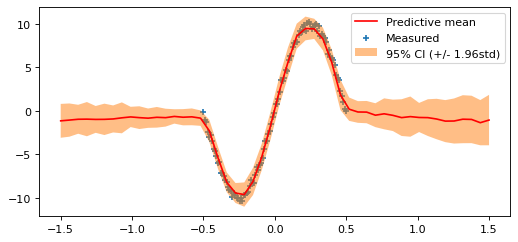

In [10]:
X_test = np.linspace(-1.5, 1.5, 50).reshape(-1, 1)
Y_test = np.zeros([len(X_test), 100])
for j in range(100):
    Y_test[:,j]= np.squeeze(model.predict(X_test))
Pred = np.mean(Y_test, axis=1)
Stdv = np.std(Y_test, axis=1)

X_test = np.squeeze(X_test)  
cm = 1/2.54 
fig, ax = plt.subplots(1, figsize=(17*cm, 8*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.plot(X_test, Pred, 'r-', label='Predictive mean');
ax.scatter(X,Y, marker='+', label='Measured');
ax.fill_between(X_test,Pred+1.96*Stdv,Pred-1.96*Stdv,
                 alpha=0.5, label='95% CI (+/- 1.96std)')
ax.legend()